### 1) Google Drive’ı bağla ve zip’i aç

In [3]:
# 1) Google Drive’ı bağla ve zip’i aç
from google.colab import drive
drive.mount('/content/drive')

!unzip -q /content/drive/MyDrive/_face-recognition-system.v1i.darknet.zip -d /content/face_dataset

Mounted at /content/drive


### 2) Eğitim ve validasyon klasörleri için %80/%20 split

In [ ]:
import os, random, shutil
from glob import glob

base = "/content/face_dataset/_face-recognition-system.v1i.darknet"
img_train = os.path.join(base, "images/train")
lbl_train = os.path.join(base, "labels/train")
img_val   = os.path.join(base, "images/valid")
lbl_val   = os.path.join(base, "labels/valid")

os.makedirs(img_val, exist_ok=True)
os.makedirs(lbl_val, exist_ok=True)

files = glob(os.path.join(img_train, "*.jpg"))
random.shuffle(files)
n_val = int(0.2 * len(files))

for img in files[:n_val]:
    fn = os.path.basename(img)
    lbl = os.path.join(lbl_train, fn.replace('.jpg', '.txt'))
    shutil.move(img, os.path.join(img_val, fn))
    if os.path.exists(lbl):
        shutil.move(lbl, os.path.join(lbl_val, os.path.basename(lbl)))

print(f"{n_val} görsel valid klasörüne taşındı.")

69 görsel valid klasörüne taşındı.


### 3) data.yaml dosyasını tek seferde doğru şekilde oluştur

In [6]:
%%bash
cat << 'EOF' > /content/face_dataset/_face-recognition-system.v1i.darknet/data.yaml
train: /content/face_dataset/_face-recognition-system.v1i.darknet/images/train
val:   /content/face_dataset/_face-recognition-system.v1i.darknet/images/valid

nc: 1
names: ['myface']
EOF

### 4) YOLOv5 kodunu klonla ve bağımlılıkları yükle

In [7]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17516/17516), 16.62 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (12001/12001), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 

### 5) Modeli eğit

In [ ]:
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 50 \
  --data /content/face_dataset/_face-recognition-system.v1i.darknet/data.yaml \
  --weights yolov5s.pt \
  --name face-detector

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-07-18 12:11:52.868331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752840713.121662    4011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752840713.197916    4011 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

### 6) ONNX’e dönüştür

In [ ]:
!python export.py \
  --weights runs/train/face-detector/weights/best.pt \
  --include onnx

export: data=data/coco128.yaml, weights=['runs/train/face-detector/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/face-detector/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0...
ONNX: export success ✅ 2.9s, saved as runs/train/face

### 7) ONNX dosyasını Drive’a kopyala (klasör değil, dosya olarak)

In [ ]:
!mkdir -p /content/drive/MyDrive/face_recognition_models
!cp runs/train/face-detector/weights/best.onnx /content/drive/MyDrive/face_recognition_models/

### 8) ONNX Runtime ile hızlı bir test

In [ ]:
!pip install -q onnxruntime

import onnxruntime as ort
import numpy as np

onnx_path = '/content/drive/MyDrive/face_recognition_models/best.onnx'
session = ort.InferenceSession(onnx_path)

inp = session.get_inputs()[0]
out = session.get_outputs()[0]
print(f"Input:  {inp.name}, shape={inp.shape}")
print(f"Output: {out.name}")

dummy = np.random.rand(1, *inp.shape[1:]).astype(np.float32)
res = session.run([out.name], {inp.name: dummy})
print("Çıktı shape:", res[0].shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00
Input:  images, shape=[1, 3, 640, 640]
Output: output0
Çıktı shape: (1, 25200, 6)


### 9) ONNX modelini indir (isteğe bağlı)

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/face_recognition_models/best.onnx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 10) Bir adet görselde yüz tespiti testi

In [ ]:
!python detect.py \
  --weights runs/train/face-detector/weights/best.pt \
  --img 640 \
  --conf 0.25 \
  --source /content/face_dataset/_face-recognition-system.v1i.darknet/images/train/face_003.jpg

detect: weights=['runs/train/face-detector/weights/best.pt'], source=/content/face_dataset/_face-recognition-system.v1i.darknet/images/train/face_003.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/face_dataset/_face-recognition-system.v1i.darknet/images/train/face_003.jpg: 640x640 1 myface, 11.5ms
Speed: 0.6ms pre-process, 11.5ms inference, 125.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/dete

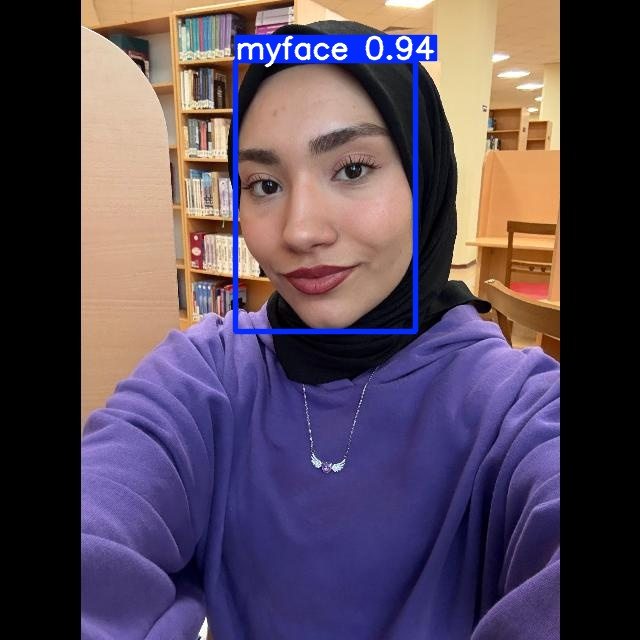

In [18]:
from IPython.display import Image
Image(filename='runs/detect/exp/face_003.jpg')  # exp yerine klasörün doğru ismini koy


### 11) Tüm train klasörünü batch olarak test et

In [ ]:
!python detect.py \
  --weights runs/train/face-detector/weights/best.pt \
  --img 640 \
  --conf 0.25 \
  --source /content/face_dataset/_face-recognition-system.v1i.darknet/images/train \
  --save-txt \
  --project runs/detect \
  --name test_results \
  --exist-ok

detect: weights=['runs/train/face-detector/weights/best.pt'], source=/content/face_dataset/_face-recognition-system.v1i.darknet/images/train, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/280 /content/face_dataset/_face-recognition-system.v1i.darknet/images/train/face_001.jpg: 640x640 1 myface, 11.6ms
image 2/280 /content/face_dataset/_face-recognition-system.v1i.darknet/images/train/face_003.jpg: 640x640 1 myface, 11.5ms

### 12) Validation set’i kullanarak performans ölçümü

In [ ]:
!python val.py \
  --weights runs/train/face-detector/weights/best.pt \
  --data /content/face_dataset/_face-recognition-system.v1i.darknet/data.yaml \
  --task val \
  --save-txt

val: data=/content/face_dataset/_face-recognition-system.v1i.darknet/data.yaml, weights=['runs/train/face-detector/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/face_dataset/_face-recognition-system.v1i.darknet/labels/valid.cache... 156 images, 0 backgrounds, 0 corrupt: 100% 156/156 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 5/5 [00:04<00:00,  1.08it/s]
                   all        156        156          1      0.998      0.995      0.883
Speed: 0.3ms pre-process, 